In [4]:
from statsbombpy import sb
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, log_loss
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Matches Analysis

In [5]:
competitions = sb.competitions()
serie_a = competitions[competitions['competition_name'] == 'Serie A']
serie_a

c:\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
66,12,27,Italy,Serie A,male,False,False,2015/2016,2024-06-25T23:56:11.910924,None,None,2024-06-25T23:56:11.910924
67,12,86,Italy,Serie A,male,False,False,1986/1987,2023-06-18T01:55:53.343752,None,None,2023-06-18T01:55:53.343752


In [6]:
matches_1516 = sb.matches(competition_id=12, season_id=27)

c:\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [7]:
matches_napoli = matches_1516[matches_1516['home_team'].str.contains('Napoli') | matches_1516['away_team'].str.contains('Napoli')]
matches_napoli = matches_napoli.sort_values('match_date', ascending=True)
matches_napoli.reset_index(drop=True, inplace=True)
matches_napoli_filtered = matches_napoli.drop(columns=['shot_fidelity_version', 'xy_fidelity_version', 'competition', 'season', 'competition_stage', 'last_updated', 'last_updated_360', 'data_version', 'match_status', 'match_status_360'])

In [8]:
matches_napoli_filtered['home_play'] = matches_napoli_filtered['home_team'] == 'Napoli'
matches_napoli_filtered['result'] = np.where(
    matches_napoli_filtered['home_play'], 
    matches_napoli_filtered['home_score'] - matches_napoli_filtered['away_score'],  # If Napoli played at home
    matches_napoli_filtered['away_score'] - matches_napoli_filtered['home_score']   # If Napoli played away
)
matches_napoli_filtered['result'] = np.where(
    matches_napoli_filtered['result'] > 0,  # Napoli won
    "Win",
    np.where(
        matches_napoli_filtered['result'] == 0,  # Draw
        "Draw",
        "Lose"  # Napoli lost
    )
)
matches_napoli_filtered 

,match_id,match_date,kick_off,home_team,away_team,home_score,away_score,match_week,stadium,referee,home_managers,away_managers,home_play,result
0,3878546,2015-08-23,20:45:00.000,Sassuolo,Napoli,2,1,1,MAPEI Stadium - Città del Tricolore,Daniele Doveri,Eusebio Di Francesco,Maurizio Sarri,False,Lose
1,3878558,2015-08-30,20:45:00.000,Napoli,Sampdoria,2,2,2,Stadio Diego Armando Maradona,Andrea Gervasoni,Maurizio Sarri,Walter Zenga,True,Draw
2,3878597,2015-09-13,15:00:00.000,Empoli,Napoli,2,2,3,Stadio Carlo Castellani,Luca Banti,Marco Giampaolo,Maurizio Sarri,False,Draw
3,3878604,2015-09-20,20:45:00.000,Napoli,Lazio,5,0,4,Stadio Diego Armando Maradona,Antonio Damato,Maurizio Sarri,Stefano Pioli,True,Win
4,3879539,2015-09-23,20:45:00.000,Carpi,Napoli,0,0,5,Stadio Alberto Braglia (Modena),Gianluca Rocchi,Fabrizio Castori,Maurizio Sarri,False,Draw
5,3879548,2015-09-26,20:45:00.000,Napoli,Juventus,2,1,6,Stadio Diego Armando Maradona,Daniele Orsato,Maurizio Sarri,Massimiliano Allegri,True,Win
6,3879562,2015-10-04,20:45:00.000,AC Milan,Napoli,0,4,7,Stadio Giuseppe Meazza,Nicola Rizzoli,Siniša Mihajlović,Maurizio Sarri,False,Win
7,3879572,2015-10-18,15:00:00.000,Napoli,Fiorentina,2,1,8,Stadio Diego Armando Maradona,Luca Banti,Maurizio Sarri,Paulo Manuel Carvalho de Sousa,True,Win
8,3879581,2015-10-25,20:45:00.000,Chievo,Napoli,0,1,9,Stadio Marc''Antonio Bentegodi,Davide Massa,Rolando Maran,Maurizio Sarri,False,Win
9,3879593,2015-10-28,21:45:00.000,Napoli,Palermo,2,0,10,Stadio Diego Armando Maradona,Piero Giacomelli,Maurizio Sarri,Giuseppe Iachini,True,Win


In [9]:
matches_napoli_filtered.to_csv('Sources/matches_napoli_filtered.csv')

In [10]:
# Count the number of occurrences for each result
results = matches_napoli_filtered['result'].value_counts()
results

result
Win     25
Draw     7
Lose     6
Name: count, dtype: int64

In [11]:
home_wins = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == True) & (matches_napoli_filtered['result'] == 'Win')]
print("Home Wins count:",home_wins.__len__())
away_wins = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == False) & (matches_napoli_filtered['result'] == 'Win')]
print("Away Wins count:",away_wins.__len__())
home_losses = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == True) & (matches_napoli_filtered['result'] == 'Lose')]
print("Home Losses count:",home_losses.__len__())
away_losses = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == False) & (matches_napoli_filtered['result'] == 'Lose')]
print("Away Losses count:",away_losses.__len__())
home_draws = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == True) & (matches_napoli_filtered['result'] == 'Draw')]
print("Home Draws count:",home_draws.__len__())
away_draws = matches_napoli_filtered[(matches_napoli_filtered['home_play'] == False) & (matches_napoli_filtered['result'] == 'Draw')]
print("Away Draws count:",away_draws.__len__())

Home Wins count: 16
Away Wins count: 9
Home Losses count: 0
Away Losses count: 6
Home Draws count: 3
Away Draws count: 4


# Team Analysis

In [12]:
data = {
    'home_wins': [home_wins.__len__()],
    'away_wins': [away_wins.__len__()],
    'home_losses': [home_losses.__len__()],
    'away_losses': [away_losses.__len__()],
    'home_draws': [home_draws.__len__()],
    'away_draws': [away_draws.__len__()],
    'total_wins': [home_wins.__len__() + away_wins.__len__()],
    'total_losses': [home_losses.__len__() + away_losses.__len__()],
    'total_draws': [home_draws.__len__() + away_draws.__len__()]
}

In [13]:
napoli_performances = pd.DataFrame(data)
home_game = matches_napoli_filtered[matches_napoli_filtered['home_play'] == True]
away_game = matches_napoli_filtered[matches_napoli_filtered['home_play'] == False]

napoli_performances['goals_made'] = [home_game['home_score'].sum() + away_game['away_score'].sum()]
napoli_performances['goals_conceded'] = [home_game['away_score'].sum() + away_game['home_score'].sum()]
napoli_performances['goal_difference'] = [napoli_performances['goals_made'][0] - napoli_performances['goals_conceded'][0]]

# Events analysis

In [54]:
# Assume matches_napoli_filtered["match_id"].unique() contains the match IDs
match_ids = matches_napoli_filtered["match_id"].unique()

# Initialize an empty list to store the event data for each match
events_napoli = []

# Loop through each match_id and fetch events
for match_id in match_ids:
    events = sb.events(match_id=match_id)  # Fetch events for each match
    events_napoli.append(events)  # Append the events data to the list

# Combine all events into a single DataFrame
events_napoli = pd.concat(events_napoli, ignore_index=True)

# Display the final DataFrame containing events for all Napoli matches

c:\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [55]:
events_napoli['type'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Clearance', 'Pressure', 'Interception', 'Miscontrol',
       'Shot', 'Block', 'Goal Keeper', 'Ball Recovery', 'Foul Committed',
       'Foul Won', 'Dribbled Past', 'Dribble', 'Dispossessed', 'Shield',
       '50/50', 'Half End', 'Injury Stoppage', 'Player Off',
       'Substitution', 'Player On', 'Tactical Shift', 'Offside',
       'Referee Ball-Drop', 'Error', 'Bad Behaviour', 'Own Goal For',
       'Own Goal Against'], dtype=object)

In [56]:
index_to_drop = events_napoli[events_napoli['type'].isin(['50/50', 'Half Start', 'Half End', 'Injury Stoppage', 'Player Off', 'Substitution', 'Player On', 'Tactical Shift', 'Referee Ball-Drop', 'Own Goal For', 'Own Goal Against'])].index
events_napoli.drop(index_to_drop, inplace=True)

In [57]:
events_napoli['type'].unique()

array(['Starting XI', 'Pass', 'Ball Receipt*', 'Carry', 'Duel',
       'Clearance', 'Pressure', 'Interception', 'Miscontrol', 'Shot',
       'Block', 'Goal Keeper', 'Ball Recovery', 'Foul Committed',
       'Foul Won', 'Dribbled Past', 'Dribble', 'Dispossessed', 'Shield',
       'Offside', 'Error', 'Bad Behaviour'], dtype=object)

# Passes Analysis

## Analysis

<Axes: title={'center': 'Number of Passes made by Napoli players'}, xlabel='player'>

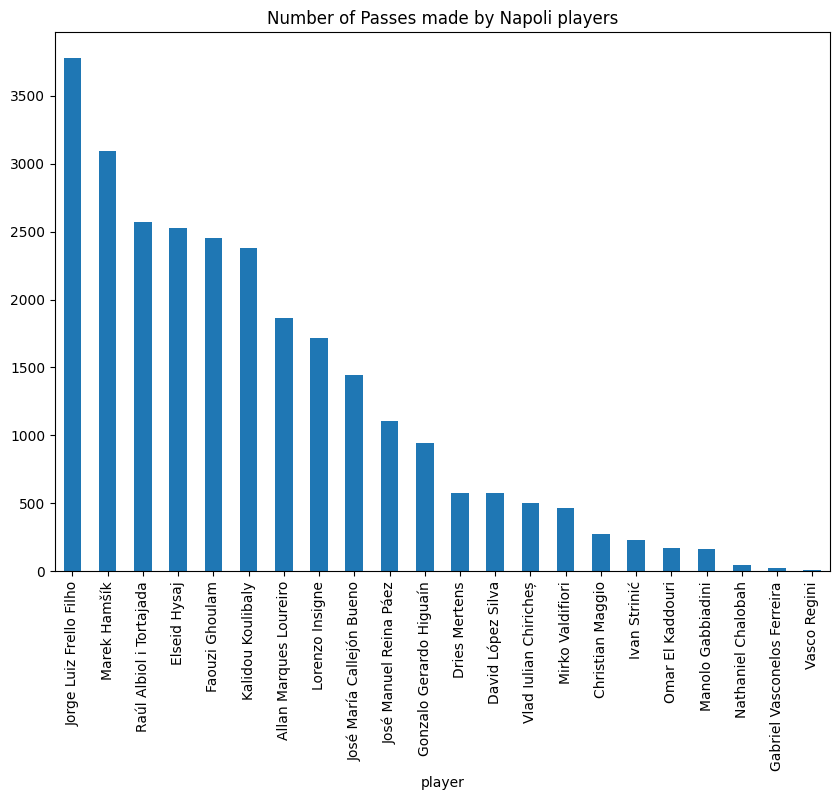

In [58]:
passes = events_napoli[events_napoli['type'] == 'Pass'].dropna(axis=1, how='all')
passes_napoli = passes[passes['team'] == 'Napoli']
plt.figure(figsize=(10, 7))
plt.title('Number of Passes made by Napoli players')
passes_napoli['player'].value_counts().plot(kind='bar')

In [59]:
passes_napoli['pass_goal_assist'].value_counts()

pass_goal_assist
True    55
Name: count, dtype: int64

In [60]:
print("Number of passes leading to a goal or assist:")
players_assists = passes_napoli[passes_napoli['pass_goal_assist'] == True].groupby('player')['pass_goal_assist'].count().sort_values(ascending=False)
players_assists

Number of passes leading to a goal or assist:


player
Marek Hamšík                 11
Lorenzo Insigne              10
José María Callejón Bueno     6
Allan Marques Loureiro        5
Dries Mertens                 5
Jorge Luiz Frello Filho       4
Faouzi Ghoulam                3
Manolo Gabbiadini             3
Elseid Hysaj                  2
Gonzalo Gerardo Higuaín       2
Omar El Kaddouri              2
David López Silva             1
Raúl Albiol i Tortajada       1
Name: pass_goal_assist, dtype: int64

In [177]:
print("Number of passes leading to a shot:")
passes_to_shot = passes_napoli[passes_napoli['pass_shot_assist'] == True].groupby('player')['pass_shot_assist'].count().sort_values(ascending=False)
passes_to_shot

Number of passes leading to a shot:


player
Marek Hamšík                 81
Jorge Luiz Frello Filho      63
Lorenzo Insigne              58
Gonzalo Gerardo Higuaín      47
José María Callejón Bueno    40
Allan Marques Loureiro       35
Faouzi Ghoulam               28
Dries Mertens                26
Elseid Hysaj                 24
Mirko Valdifiori             12
Manolo Gabbiadini            10
Kalidou Koulibaly             9
Omar El Kaddouri              7
David López Silva             6
Raúl Albiol i Tortajada       4
Christian Maggio              2
Nathaniel Chalobah            2
Ivan Strinić                  1
José Manuel Reina Páez        1
Name: pass_shot_assist, dtype: int64

## Predicting probability of a pass to be an assist

Find useful features to make the prediction

In [33]:
#deleting not useful features
passes_napoli_filtered = passes_napoli.drop(columns=['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'related_events', 'pass_recipient_id', 'pass_recipient', 'off_camera', 'pass_assisted_shot_id', 'player_id', 'possession_team_id', 'team_id', 'type', 'pass_outcome', 'pass_straight'])

### Data Type Format Fix in order to fit ML algorithms

In [34]:
passes_napoli_export = passes_napoli_filtered.copy()
passes_napoli_filtered = passes_napoli_filtered.drop(columns=['match_id', 'player'])

**LIST OF VALUES**

In [35]:
passes_napoli_filtered[['x_start', 'y_start']] = pd.DataFrame(passes_napoli_filtered['location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=passes_napoli_filtered.index)
passes_napoli_filtered = passes_napoli_filtered.drop('location', axis=1)
passes_napoli_filtered[['x_end', 'y_end']] = pd.DataFrame(passes_napoli_filtered['pass_end_location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=passes_napoli_filtered.index)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_end_location', axis=1)

**STRINGS**

In [36]:
# Get unique values in 'pass_body_part' column
unique_body_parts = passes_napoli_filtered['pass_body_part'].unique()

# Create a mapping of unique body parts to float values
mapping = {part: i for i, part in enumerate(unique_body_parts)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_body_part_float'] = passes_napoli_filtered['pass_body_part'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_body_part', axis=1)


In [37]:
# Get unique values in 'pass_type' column
unique_pass_type = passes_napoli_filtered['pass_type'].unique()

# Create a mapping of unique pass type to float values
mapping = {part: i for i, part in enumerate(unique_pass_type)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_type_float'] = passes_napoli_filtered['pass_type'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_type', axis=1)


In [38]:
# Get unique values in 'pass_height' column
unique_pass_height = passes_napoli_filtered['pass_height'].unique()

# Create a mapping of unique pass height to float values
mapping = {part: i for i, part in enumerate(unique_pass_height)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_height_float'] = passes_napoli_filtered['pass_height'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_height', axis=1)


In [39]:
# Get unique values in 'pass_technique' column
unique_pass_height = passes_napoli_filtered['pass_technique'].unique()

# Create a mapping of unique pass height to float values
mapping = {part: i for i, part in enumerate(unique_pass_height)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['pass_technique_float'] = passes_napoli_filtered['pass_technique'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('pass_technique', axis=1)


In [40]:
# Get unique values in 'position' column
unique_position = passes_napoli_filtered['position'].unique()

# Create a mapping of unique pass height to float values
mapping = {part: i for i, part in enumerate(unique_position)}

# Replace the original string values with their mapped float values
passes_napoli_filtered['position_float'] = passes_napoli_filtered['position'].map(mapping)
passes_napoli_filtered = passes_napoli_filtered.drop('position', axis=1)


### ML Models 

In [41]:
only_assist_df = passes_napoli_filtered[passes_napoli_filtered["pass_goal_assist"] == True].drop(columns="pass_goal_assist")

# Select columns with object dtype
object_columns = passes_napoli_filtered.select_dtypes(include='object').columns

In [42]:
only_assist_df = passes_napoli_filtered[passes_napoli_filtered["pass_goal_assist"] == True].drop(columns="pass_goal_assist")

# Select columns with object dtype
object_columns = passes_napoli_filtered.select_dtypes(include='object').columns

# Replace values in object columns
passes_napoli_filtered[object_columns] = passes_napoli_filtered[object_columns].fillna(False)

passes_napoli_filtered[object_columns] = passes_napoli_filtered[object_columns].astype('bool')

In [43]:
X = passes_napoli_filtered.drop(columns=['pass_goal_assist'])
y = passes_napoli_filtered['pass_goal_assist']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
model_entr = RandomForestClassifier(criterion='entropy')
model_entr.fit(X_train, y_train)
print("Entropy Criterion Model Score", model_entr.score(X_test, y_test))
# Get feature importances using entropoy criterion
importances_entropy = model_entr.feature_importances_
model_gini = RandomForestClassifier(criterion='gini')
model_gini.fit(X_train, y_train)
print("Gini Index Criterion Model Score", model_gini.score(X_test, y_test))
# Get feature importances using gini criterion
importances_gini = model_gini.feature_importances_
model_logloss = RandomForestClassifier(criterion='log_loss')
model_logloss.fit(X_train, y_train)
print("Log Loss criterion Model Score:", model_logloss.score(X_test, y_test))
# Get feature importances using log_loss criterion
importances_log_loss = model_logloss.feature_importances_

Entropy Criterion Model Score 0.9975845410628019
Gini Index Criterion Model Score 0.9975845410628019
Log Loss criterion Model Score: 0.9975845410628019


In [45]:
pred = model_entr.predict(only_assist_df)
print("Accuracy only on Assist Entropy Criterion", pred.sum()/pred.__len__())

# Predict probabilities for the test set
y_prob_entr = model_entr.predict_proba(X_test)[:, 1]  # Get the probability for the 'assist' class (class 1)

# Evaluate the model using ROC-AUC and Log Loss
roc_auc = roc_auc_score(y_test, y_prob_entr)
logloss = log_loss(y_test, y_prob_entr)

print(f"ROC-AUC Score: {roc_auc}")
print(f"Log Loss: {logloss}")

Accuracy only on Assist Entropy Criterion 0.7454545454545455
ROC-AUC Score: 0.7447956215883202
Log Loss: 0.04644816037936967


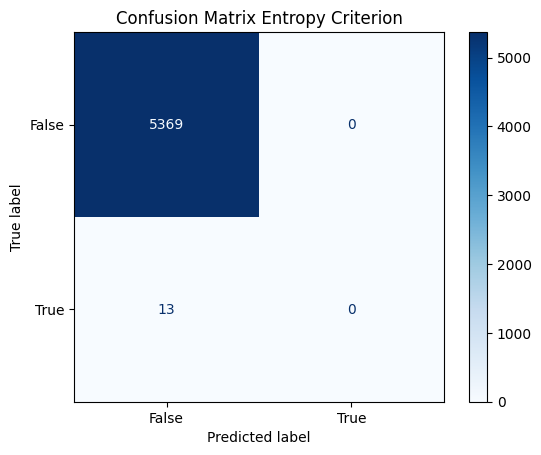

In [46]:
y_pred_entr = model_entr.predict(X_test)

cm_entr = confusion_matrix(y_test, y_pred_entr)

# Optionally, visualize the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_entr, display_labels=model_entr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Entropy Criterion')
plt.show()

In [47]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

print("XGB Model Score:", model_xgb.score(X_test, y_test))

importances_xgb = model_xgb.feature_importances_

XGB Model Score: 0.9975845410628019


In [48]:
# Predict probabilities for the test set
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]  # Get the probability for the 'assist' class (class 1)

# Evaluate the model using ROC-AUC and Log Loss
roc_auc = roc_auc_score(y_test, y_prob_xgb)
logloss = log_loss(y_test, y_prob_xgb)

print(f"ROC-AUC Score: {roc_auc}")
print(f"Log Loss: {logloss}")

ROC-AUC Score: 0.8783042251099618
Log Loss: 0.017103344095776463


ROC-AUC and Log Loss value are way better for the XGBoost model

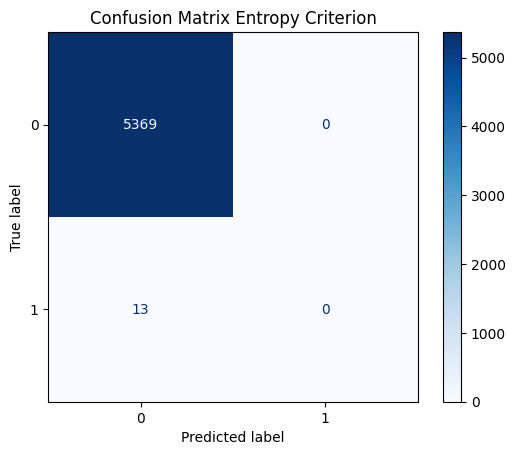

In [49]:
y_pred_xgb = model_entr.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Optionally, visualize the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model_xgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Entropy Criterion')
plt.show()

<Figure size 1000x1000 with 0 Axes>

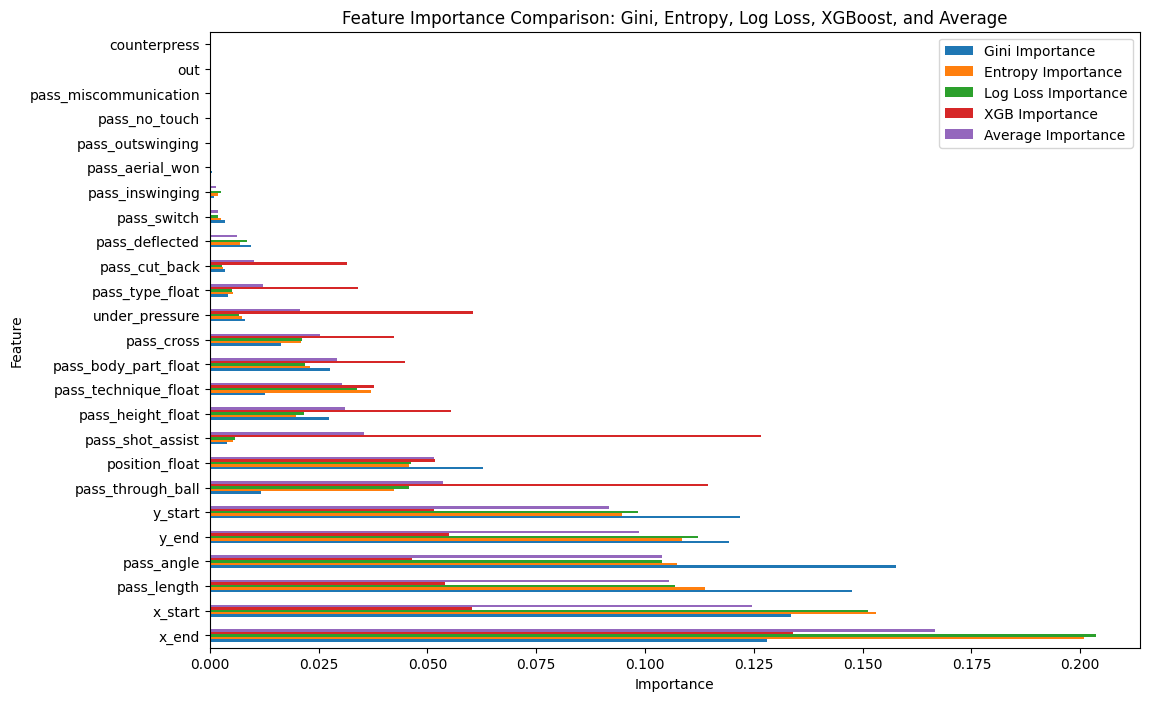

In [50]:
importances_mean = np.mean([importances_entropy, importances_gini, importances_log_loss, importances_xgb], axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': importances_gini,
    'Entropy Importance': importances_entropy,
    'Log Loss Importance': importances_log_loss,
    'XGB Importance': importances_xgb
})

# Calculate the average importance across the three criteria
importance_df['Average Importance'] = importance_df[['Gini Importance', 'Entropy Importance', 'Log Loss Importance', 'XGB Importance']].mean(axis=1)

importance_df = importance_df.sort_values('Average Importance', ascending=False)

# Plot the feature importances for all criteria and the average
plt.figure(figsize=(10, 10))
importance_df.plot(x='Feature', y=['Gini Importance', 'Entropy Importance', 'Log Loss Importance', 'XGB Importance', 'Average Importance'], kind='barh', figsize=(12, 8))
plt.title('Feature Importance Comparison: Gini, Entropy, Log Loss, XGBoost, and Average')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Predicted probability of Assist will be used as Expected Assist(xA) from a pass**

In [68]:
passes_napoli['xA'] = model_xgb.predict_proba(X)[:, 1]

C:\Users\gekth\AppData\Local\Temp\ipykernel_33664\966874305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_napoli['xA'] = model_xgb.predict_proba(X)[:, 1]


In [52]:
print("Top players by Expected Assists:")
players_xA = passes_napoli.groupby('player')['xA'].sum().sort_values(ascending=False)
players_xA

Top players by Expected Assists:


player
Marek Hamšík                   8.386888
Lorenzo Insigne                8.058965
Allan Marques Loureiro         5.057558
Jorge Luiz Frello Filho        4.457499
José María Callejón Bueno      4.009930
Dries Mertens                  3.410864
Gonzalo Gerardo Higuaín        2.399893
Faouzi Ghoulam                 2.074198
Elseid Hysaj                   2.051194
Manolo Gabbiadini              1.822027
David López Silva              1.026265
Raúl Albiol i Tortajada        0.991957
Omar El Kaddouri               0.896727
Mirko Valdifiori               0.202675
Kalidou Koulibaly              0.110876
José Manuel Reina Páez         0.062138
Ivan Strinić                   0.033660
Vlad Iulian Chiricheș          0.022229
Christian Maggio               0.019105
Nathaniel Chalobah             0.000491
Gabriel Vasconelos Ferreira    0.000298
Vasco Regini                   0.000013
Name: xA, dtype: float32

In [61]:
print("Top players by Expected Assists - Actual Assists:")
(players_xA-players_assists).dropna().sort_values(ascending=False)

Top players by Expected Assists - Actual Assists:


player
Jorge Luiz Frello Filho      0.457499
Gonzalo Gerardo Higuaín      0.399893
Allan Marques Loureiro       0.057558
Elseid Hysaj                 0.051194
David López Silva            0.026265
Raúl Albiol i Tortajada     -0.008043
Faouzi Ghoulam              -0.925802
Omar El Kaddouri            -1.103273
Manolo Gabbiadini           -1.177973
Dries Mertens               -1.589136
Lorenzo Insigne             -1.941035
José María Callejón Bueno   -1.990070
Marek Hamšík                -2.613112
dtype: float64

In [70]:
passes_napoli_export['xA'] = passes_napoli['xA']

In [143]:
passes_napoli_export

,counterpress,location,match_id,out,pass_aerial_won,pass_angle,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_outswinging,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,player,position,under_pressure,xA
6,NaN,"[61.0, 40.1]",3878546,NaN,NaN,2.102520,Right Foot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Kick Off,Gonzalo Gerardo Higuaín,Right Center Forward,NaN,0.000006
7,NaN,"[59.1, 41.6]",3878546,NaN,NaN,2.726518,Right Foot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Dries Mertens,Left Center Forward,NaN,0.000260
8,NaN,"[47.3, 46.8]",3878546,NaN,NaN,-1.885554,Right Foot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Raúl Albiol i Tortajada,Right Center Back,NaN,0.000001
9,NaN,"[45.9, 42.5]",3878546,NaN,NaN,0.512560,Right Foot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Vlad Iulian Chiricheș,Left Center Back,NaN,0.000007
10,NaN,"[105.5, 80.0]",3878546,NaN,NaN,-0.941423,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Throw-in,Christian Maggio,Right Back,NaN,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148264,NaN,"[82.9, 38.1]",3879867,NaN,NaN,-0.815489,Right Foot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Jorge Luiz Frello Filho,Center Defensive Midfield,NaN,0.004677
148265,NaN,"[42.0, 48.1]",3879867,NaN,NaN,3.078234,Right Foot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Vlad Iulian Chiricheș,Right Center Back,NaN,0.000007
148266,NaN,"[10.0, 50.0]",3879867,NaN,NaN,-0.873509,Right Foot,NaN,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,José Manuel Reina Páez,Goalkeeper,NaN,0.000008
148267,NaN,"[56.4, 0.1]",3879867,NaN,NaN,0.791178,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Throw-in,Faouzi Ghoulam,Left Back,NaN,0.000026


In [147]:
passes_napoli_export.to_csv('Sources/passes_napoli.csv')

# Shot Analysis

## Analysis

<Axes: title={'center': 'Number of shots made by Napoli players'}, xlabel='player'>

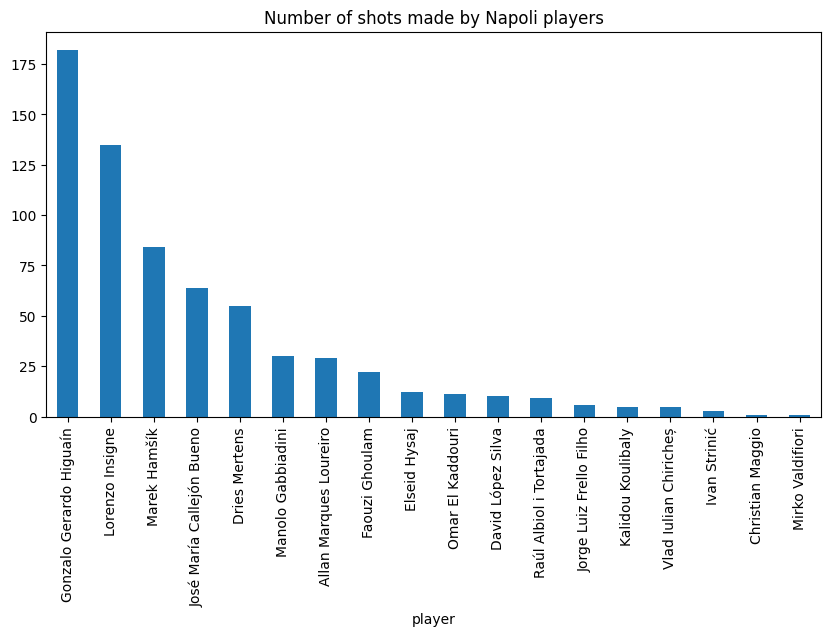

In [73]:
shots = events_napoli[events_napoli['type'] == 'Shot'].dropna(axis=1, how='all')
shots_napoli = shots[shots['team'] == 'Napoli']
plt.figure(figsize=(10, 5))
plt.title('Number of shots made by Napoli players')
players_shots = shots_napoli['player'].value_counts()
players_shots.plot(kind='bar')

In [74]:
napoli_performances['shots_made'] = players_shots.sum()

In [75]:
shots = events_napoli[events_napoli['type'] == 'Shot'].dropna(axis=1, how='all')
shots_not_napoli = shots[shots['team'] != 'Napoli']
players_nn_shots = shots_not_napoli['player'].count()
players_nn_shots

348

In [76]:
napoli_performances['shots_conceded'] = players_nn_shots

In [77]:
shots_napoli['shot_outcome'].value_counts()

shot_outcome
Off T               239
Saved               162
Blocked             147
Goal                 78
Wayward              22
Post                 11
Saved to Post         4
Saved Off Target      1
Name: count, dtype: int64

<Axes: title={'center': 'Number of goals made by Napoli players'}, xlabel='player'>

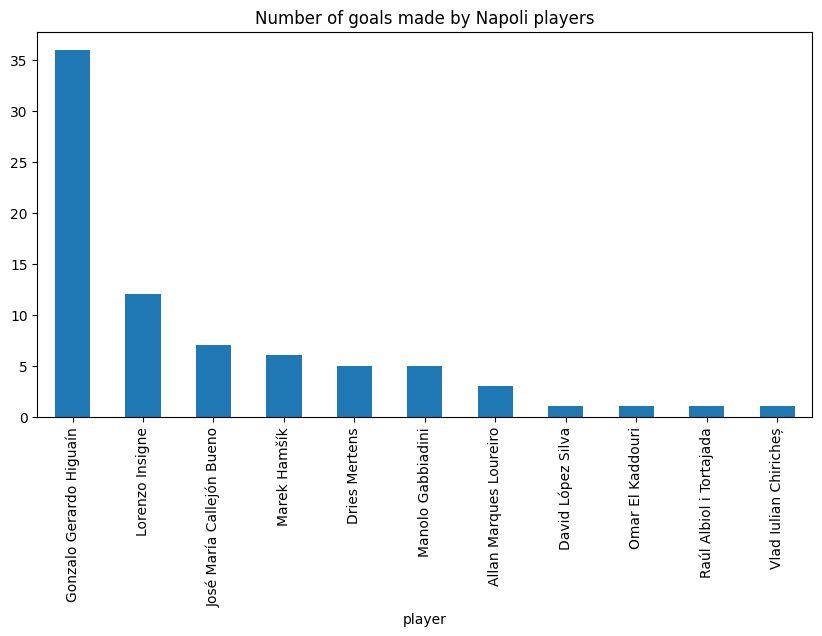

In [78]:
plt.figure(figsize=(10, 5))
plt.title('Number of goals made by Napoli players')
players_goals = shots_napoli[shots_napoli['shot_outcome'] == 'Goal'].groupby('player')['shot_outcome'].count().sort_values(ascending=False)
players_goals.plot(kind='bar')

In [79]:
# Calculate the number of goals for each player
goals_by_player = shots_napoli[shots_napoli['shot_outcome'] == 'Goal']['player'].value_counts()

# Calculate the total number of shots for each player
shots_by_player = shots_napoli['player'].value_counts()

# Calculate the conversion rate for each player
conversion_rate = goals_by_player / shots_by_player

# Find the player with the highest conversion rate
print("Player with the highest conversion rate:")
conversion_rate.sort_values(ascending=False).dropna()

Player with the highest conversion rate:


player
Vlad Iulian Chiricheș        0.200000
Gonzalo Gerardo Higuaín      0.197802
Manolo Gabbiadini            0.166667
Raúl Albiol i Tortajada      0.111111
José María Callejón Bueno    0.109375
Allan Marques Loureiro       0.103448
David López Silva            0.100000
Dries Mertens                0.090909
Omar El Kaddouri             0.090909
Lorenzo Insigne              0.088889
Marek Hamšík                 0.071429
Name: count, dtype: float64

## Predicting probability of a shot to be a Goal

Delete useless attributes

In [106]:
#deleting not useful features
shots_napoli_filtered = shots_napoli.drop(columns=['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'related_events', 'shot_key_pass_id', 'off_camera', 'match_id', 'shot_statsbomb_xg', 'player_id', 'possession_team_id', 'team_id', 'type', 'shot_freeze_frame'])

In [107]:
shots_napoli_export = shots_napoli_filtered.copy()
shots_napoli_filtered = shots_napoli_filtered.drop(columns='player')

### Data Type Format Fix in order to fit ML algorithms

**LIST OF VALUES**

In [108]:
shots_napoli_filtered[['x_start', 'y_start']] = pd.DataFrame(shots_napoli_filtered['location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=shots_napoli_filtered.index)
shots_napoli_filtered = shots_napoli_filtered.drop('location', axis=1)
shots_napoli_filtered[['x_end', 'y_end', 'height_end']] = pd.DataFrame(shots_napoli_filtered['shot_end_location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=shots_napoli_filtered.index)
shots_napoli_filtered = shots_napoli_filtered.drop('shot_end_location', axis=1)

In [109]:
shots_napoli_filtered['height_end'] = shots_napoli_filtered['height_end'].fillna(0) 

**STRINGS**

In [110]:
# Get unique values in 'position' column
unique_position = shots_napoli_filtered['position'].unique()

# Create a mapping of unique shot position to float values
mapping = {part: i for i, part in enumerate(unique_position)}

# Replace the original string values with their mapped float values
shots_napoli_filtered['position_float'] = shots_napoli_filtered['position'].map(mapping)
shots_napoli_filtered = shots_napoli_filtered.drop('position', axis=1)

In [111]:
# Get unique values in 'shot_technique' column
unique_shot_technique = shots_napoli_filtered['shot_technique'].unique()

# Create a mapping of unique shot_technique to float values
mapping = {part: i for i, part in enumerate(unique_shot_technique)}

# Replace the original string values with their mapped float values
shots_napoli_filtered['shot_technique_float'] = shots_napoli_filtered['shot_technique'].map(mapping)
shots_napoli_filtered = shots_napoli_filtered.drop('shot_technique', axis=1)

In [112]:
# Get unique values in 'shot_type' column
unique_shot_type = shots_napoli_filtered['shot_type'].unique()

# Create a mapping of unique shot_type to float values
mapping = {part: i for i, part in enumerate(unique_shot_type)}

# Replace the original string values with their mapped float values
shots_napoli_filtered['shot_type_float'] = shots_napoli_filtered['shot_type'].map(mapping)
shots_napoli_filtered = shots_napoli_filtered.drop('shot_type', axis=1)

In [113]:
# Get unique values in 'shot_body_part' column
unique_shot_body_part = shots_napoli_filtered['shot_body_part'].unique()

# Create a mapping of unique shot_body_part to float values
mapping = {part: i for i, part in enumerate(unique_shot_body_part)}

# Replace the original string values with their mapped float values
shots_napoli_filtered['shot_body_part_float'] = shots_napoli_filtered['shot_body_part'].map(mapping)
shots_napoli_filtered = shots_napoli_filtered.drop('shot_body_part', axis=1)

In [114]:
only_goals_df = shots_napoli_filtered[shots_napoli_filtered["shot_outcome"] == 'Goal'].drop(columns="shot_outcome")

shots_napoli_filtered['is_goal'] = shots_napoli_filtered['shot_outcome'].map({'Goal': True, 'Saved': False, 'Off T': False, 'Post': False, 'Wayward': False, 'Blocked': False, 'Saved to Post': False, 'Saved Off Target': False, 'Goal Off Target': False})

# Select columns with object dtype
object_columns = shots_napoli_filtered.select_dtypes(include='object').columns

# Replace values in object columns
shots_napoli_filtered[object_columns] = shots_napoli_filtered[object_columns].fillna(False)

shots_napoli_filtered[object_columns] = shots_napoli_filtered[object_columns].astype('bool')

shots_napoli_filtered = shots_napoli_filtered.drop(columns=['shot_outcome'])

## ML algortihms

In [89]:
X = shots_napoli_filtered.drop(columns=['is_goal'])
y = shots_napoli_filtered['is_goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
model_entr = RandomForestClassifier(criterion='entropy')
model_entr.fit(X_train, y_train)
print("Entropy Criterion Model Score", model_entr.score(X_test, y_test))
# Get feature importances using entropoy criterion
importances_entropy = model_entr.feature_importances_
model_gini = RandomForestClassifier(criterion='gini')
model_gini.fit(X_train, y_train)
print("Gini Index Criterion Model Score", model_gini.score(X_test, y_test))
# Get feature importances using gini criterion
importances_gini = model_gini.feature_importances_
model_logloss = RandomForestClassifier(criterion='log_loss')
model_logloss.fit(X_train, y_train)
print("Log Loss criterion Model Score:", model_logloss.score(X_test, y_test))
# Get feature importances using log_loss criterion
importances_log_loss = model_logloss.feature_importances_

Entropy Criterion Model Score 0.9774436090225563
Gini Index Criterion Model Score 0.9699248120300752
Log Loss criterion Model Score: 0.9849624060150376


In [91]:
pred = model_entr.predict(only_goals_df)
print("Accuracy only on Goal Entropy Criterion", pred.sum()/pred.__len__())

# Predict probabilities for the test set
y_prob_entr = model_entr.predict_proba(X_test)[:, 1]  # Get the probability for the 'assist' class (class 1)

# Evaluate the model using ROC-AUC and Log Loss
roc_auc = roc_auc_score(y_test, y_prob_entr)
logloss = log_loss(y_test, y_prob_entr)

print(f"ROC-AUC Score: {roc_auc}")
print(f"Log Loss: {logloss}")

Accuracy only on Goal Entropy Criterion 0.9615384615384616
ROC-AUC Score: 0.9990766389658357
Log Loss: 0.08900391175938892


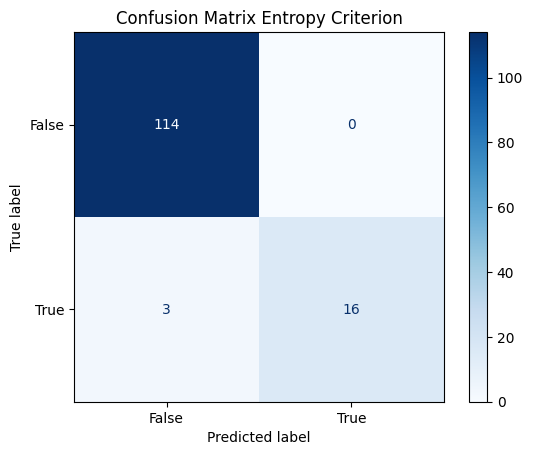

In [92]:
y_pred_entr = model_entr.predict(X_test)

cm_entr = confusion_matrix(y_test, y_pred_entr)

# Optionally, visualize the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_entr, display_labels=model_entr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Entropy Criterion')
plt.show()

In [93]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

print("XGB Model Score:", model_xgb.score(X_test, y_test))

importances_xgb = model_xgb.feature_importances_

XGB Model Score: 1.0


In [94]:
# Predict probabilities for the test set
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]  # Get the probability for the 'assist' class (class 1)

# Evaluate the model using ROC-AUC and Log Loss
roc_auc = roc_auc_score(y_test, y_prob_xgb)
logloss = log_loss(y_test, y_prob_xgb)

print(f"ROC-AUC Score: {roc_auc}")
print(f"Log Loss: {logloss}")

ROC-AUC Score: 1.0
Log Loss: 0.007178399550780603


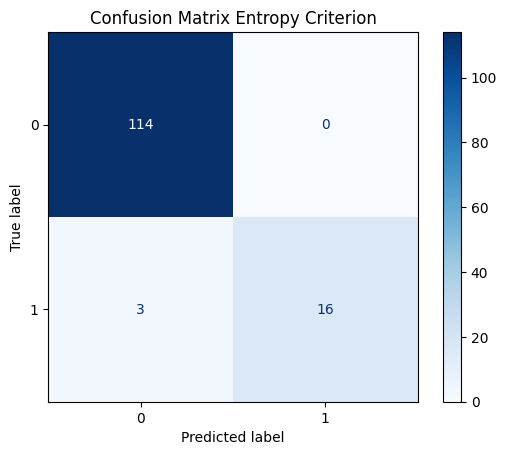

In [95]:
y_pred_xgb = model_entr.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Optionally, visualize the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model_xgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Entropy Criterion')
plt.show()

<Figure size 1000x1000 with 0 Axes>

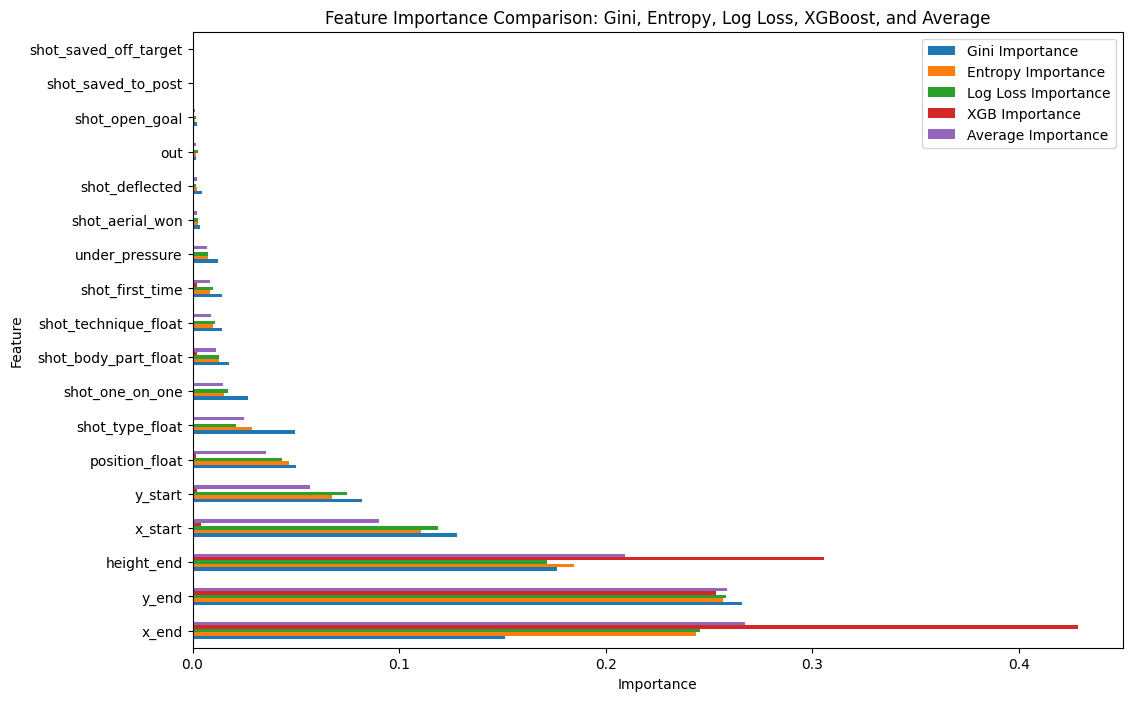

In [96]:
importances_mean = np.mean([importances_entropy, importances_gini, importances_log_loss, importances_xgb], axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': importances_gini,
    'Entropy Importance': importances_entropy,
    'Log Loss Importance': importances_log_loss,
    'XGB Importance': importances_xgb
})

# Calculate the average importance across the three criteria
importance_df['Average Importance'] = importance_df[['Gini Importance', 'Entropy Importance', 'Log Loss Importance', 'XGB Importance']].mean(axis=1)

importance_df = importance_df.sort_values('Average Importance', ascending=False)

# Plot the feature importances for all criteria and the average
plt.figure(figsize=(10, 10))
importance_df.plot(x='Feature', y=['Gini Importance', 'Entropy Importance', 'Log Loss Importance', 'XGB Importance', 'Average Importance'], kind='barh', figsize=(12, 8))
plt.title('Feature Importance Comparison: Gini, Entropy, Log Loss, XGBoost, and Average')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [97]:
importance_df

,Feature,Gini Importance,Entropy Importance,Log Loss Importance,XGB Importance,Average Importance
11,x_end,0.151036,0.243492,0.245578,0.428673,0.267194
12,y_end,0.266041,0.256732,0.258107,0.253427,0.258577
13,height_end,0.176192,0.184582,0.171531,0.305562,0.209466
9,x_start,0.128084,0.110671,0.118889,0.004271,0.090479
10,y_start,0.082231,0.067364,0.074959,0.002166,0.056680
14,position_float,0.050180,0.046604,0.043208,0.001505,0.035374
16,shot_type_float,0.049557,0.028709,0.021189,0.000000,0.024864
4,shot_one_on_one,0.026633,0.014995,0.017081,0.000000,0.014677
17,shot_body_part_float,0.017464,0.012675,0.012586,0.002387,0.011278
15,shot_technique_float,0.014026,0.010137,0.010957,0.000000,0.008780


In [98]:
important_features = importance_df[importance_df['Average Importance'] > 0.005]['Feature']
shots_napoli_if = shots_napoli_filtered[important_features]


In [99]:
shots_napoli['xG'] = model_xgb.predict_proba(X)[:, 1]

In [100]:
print("Top players by Expected Goals:")
players_xG = shots_napoli.groupby('player')['xG'].sum().sort_values(ascending=False)
players_xG

Top players by Expected Goals:


player
Gonzalo Gerardo Higuaín      36.026913
Lorenzo Insigne              11.922057
José María Callejón Bueno     6.945088
Marek Hamšík                  5.805957
Dries Mertens                 5.065881
Manolo Gabbiadini             4.930614
Allan Marques Loureiro        2.993061
Omar El Kaddouri              1.016721
Raúl Albiol i Tortajada       1.010780
David López Silva             1.008688
Vlad Iulian Chiricheș         0.998071
Faouzi Ghoulam                0.041996
Elseid Hysaj                  0.019599
Kalidou Koulibaly             0.018847
Jorge Luiz Frello Filho       0.012865
Ivan Strinić                  0.004115
Mirko Valdifiori              0.002576
Christian Maggio              0.001482
Name: xG, dtype: float32

In [101]:
print("Top players by Expected Goals - Actual Goals:")
(players_xG-players_goals).dropna().sort_values(ascending=False)

Top players by Expected Goals - Actual Goals:


player
Dries Mertens                0.065881
Gonzalo Gerardo Higuaín      0.026913
Omar El Kaddouri             0.016721
Raúl Albiol i Tortajada      0.010780
David López Silva            0.008688
Vlad Iulian Chiricheș       -0.001929
Allan Marques Loureiro      -0.006939
José María Callejón Bueno   -0.054912
Manolo Gabbiadini           -0.069386
Lorenzo Insigne             -0.077943
Marek Hamšík                -0.194043
dtype: float64

In [118]:
shots_napoli_export['xG'] = shots_napoli['xG']
shots_napoli_export['match_id'] = shots_napoli['match_id']

In [127]:
shots_napoli_export.to_csv('Sources/shots_napoli_filtered.csv')

# Carries Analysis

## Developing Dangerous Carries Index (DCI)

In [128]:
carries = events_napoli[events_napoli['type'] == 'Carry'].dropna(axis=1, how='all')
carries_napoli = carries[carries['team'] == 'Napoli']

In [129]:
carries_filtered = carries_napoli.drop(columns=['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'related_events', 'match_id', 'player_id', 'possession_team_id', 'team_id', 'type', 'position', 'under_pressure'])

In [130]:
carries_filtered[['x_start', 'y_start']] = pd.DataFrame(carries_filtered['location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=carries_filtered.index)
carries_filtered = carries_filtered.drop('location', axis=1)
carries_filtered[['x_end', 'y_end']] = pd.DataFrame(carries_filtered['carry_end_location'].apply(lambda loc: eval(loc) if isinstance(loc, str) else loc).tolist(), index=carries_filtered.index)
carries_filtered = carries_filtered.drop('carry_end_location', axis=1)
carries_filtered['length'] = np.sqrt((np.abs(carries_filtered['x_end'] - carries_filtered['x_start']))**2 + (np.abs(carries_filtered['y_end'] - carries_filtered['y_start']))**2)
carries_filtered['progressive_length'] = carries_filtered['x_start'] - carries_filtered['x_end']
carries_filtered['distance_from_center'] = abs(carries_filtered['y_start'] - 40) + abs(carries_filtered['y_end'] - 40)
carries_filtered_export = carries_filtered.copy()

In [131]:
carries_filtered['length'].describe(), carries_filtered['progressive_length'].describe()

(count    20681.000000
 mean         5.128618
 std          6.820116
 min          0.000000
 25%          0.600000
 50%          2.701851
 75%          6.926038
 max         67.884092
 Name: length, dtype: float64,
 count    20681.000000
 mean        -2.585151
 std          6.697200
 min        -66.500000
 25%         -3.700000
 50%         -0.300000
 75%          0.000000
 max         30.200000
 Name: progressive_length, dtype: float64)

In [132]:
scaler = MinMaxScaler(feature_range=(-1, 1))
carries_filtered['progressive_length'] = scaler.fit_transform(carries_filtered[['progressive_length']])
carries_filtered['length'] = carries_filtered['length']/max(carries_filtered['length'])
carries_filtered['x_start'] = carries_filtered['x_start']/carries_filtered['x_end'].max()
carries_filtered['x_end'] = carries_filtered['x_start']/carries_filtered['x_end'].max()
carries_filtered['y_start'] = carries_filtered['y_start']/carries_filtered['y_end'].max()
carries_filtered['y_end'] = carries_filtered['y_start']/carries_filtered['y_end'].max()
carries_filtered['distance_from_center'] = carries_filtered['distance_from_center']/carries_filtered['distance_from_center'].max()

In [133]:
carries_filtered['progressive_length'].describe(), carries_filtered['length'].describe(), carries_filtered['x_start'].describe(), carries_filtered['x_end'].describe(), carries_filtered['y_start'].describe(), carries_filtered['y_end'].describe(), carries_filtered['distance_from_center'].describe()

(count    20681.000000
 mean         0.321920
 std          0.138515
 min         -1.000000
 25%          0.298862
 50%          0.369183
 75%          0.375388
 max          1.000000
 Name: progressive_length, dtype: float64,
 count    20681.000000
 mean         0.075550
 std          0.100467
 min          0.000000
 25%          0.008839
 50%          0.039801
 75%          0.102027
 max          1.000000
 Name: length, dtype: float64,
 count    20681.000000
 mean         0.514008
 std          0.199896
 min          0.010033
 25%          0.381271
 50%          0.526756
 75%          0.652174
 max          0.998328
 Name: x_start, dtype: float64,
 count    20681.000000
 mean         0.004298
 std          0.001671
 min          0.000084
 25%          0.003188
 50%          0.004404
 75%          0.005453
 max          0.008347
 Name: x_end, dtype: float64,
 count    20681.000000
 mean         0.465540
 std          0.287983
 min          0.001250
 25%          0.212500
 50%         

In [134]:
corr_matrix = carries_filtered.drop(columns=['player']).corr(method='pearson')

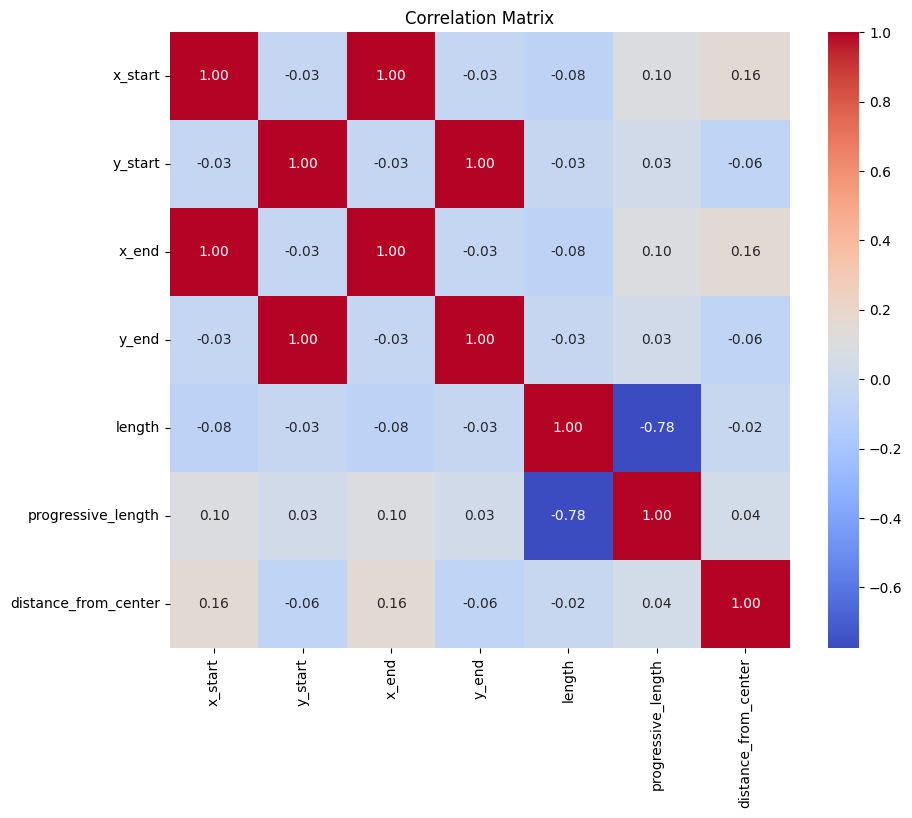

In [135]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [136]:
# Define weights for each factor
w_PL = 0.4  # Weight for progressive length
w_E = 0.3   # Weight for end position
w_L = 0.1   # Weight for carry length
w_S = 0.1   # Weight for starting position
w_C = 0.1   # Weight for distance from the center (penalty for being far from center)

# Calculate Dangerousness Carries Index (DCI)
carries_filtered['dangerousness_carries_index'] = (w_PL * carries_filtered['progressive_length'] +
                             w_E * (1 - carries_filtered['x_end']) +
                             w_L * carries_filtered['length'] +
                             w_S * (1 - carries_filtered['x_start']) -
                             w_C * carries_filtered['distance_from_center'])

In [140]:
carries_filtered_export['dangerousness_carries_index'] = carries_filtered['dangerousness_carries_index']
carries_filtered_export['match_id'] = carries_napoli['match_id']

In [142]:
carries_filtered_export.to_csv('Sources/carries_filtered.csv')

In [139]:
players_DCI = carries_filtered.groupby('player')['dangerousness_carries_index'].sum().sort_values(ascending=False)
players_DCI = players_DCI/players_DCI.max()
players_DCI

player
Jorge Luiz Frello Filho        1.000000
Marek Hamšík                   0.842016
Raúl Albiol i Tortajada        0.648841
Kalidou Koulibaly              0.631180
Allan Marques Loureiro         0.597250
Elseid Hysaj                   0.566918
Faouzi Ghoulam                 0.554894
Lorenzo Insigne                0.513581
José María Callejón Bueno      0.393699
Gonzalo Gerardo Higuaín        0.333426
José Manuel Reina Páez         0.225867
Dries Mertens                  0.195882
David López Silva              0.167161
Vlad Iulian Chiricheș          0.140314
Mirko Valdifiori               0.106871
Christian Maggio               0.055002
Omar El Kaddouri               0.052947
Ivan Strinić                   0.050689
Manolo Gabbiadini              0.047658
Nathaniel Chalobah             0.012984
Gabriel Vasconelos Ferreira    0.003661
Vasco Regini                   0.001134
Name: dangerousness_carries_index, dtype: float64

# Develop a Clustering based on xG, xA and DCI for each player 

In [323]:
# Get the indexes (player names) from each series
index_xA = set(players_xA.index)
index_xG = set(players_xG.index)
index_dCI = set(players_DCI.index)

all_players = sorted(index_xA.union(index_xG).union(index_dCI))

In [324]:
players_stats = pd.concat([players_xA, players_xG, players_DCI, players_assists, players_goals, players_shots, passes_to_shot], axis=1, keys=['xA', 'xG', 'DCI', 'A', 'G', 'Shots', 'Passes_to_Shot']).fillna(0)

In [325]:
players_stats['Total_contribution'] = players_stats['A'] + players_stats['G']
players_stats['Total_contribution'].describe()

count    22.000000
mean      6.045455
std       9.403532
min       0.000000
25%       0.000000
50%       2.000000
75%       8.000000
max      38.000000
Name: Total_contribution, dtype: float64

In [326]:
players_stats

,xA,xG,DCI,A,G,Shots,Passes_to_Shot,Total_contribution
player,,,,,,,,
Marek Hamšík,8.386888,5.805957,0.842016,11.0,6.0,84.0,81.0,17.0
Lorenzo Insigne,8.058965,11.922057,0.513581,10.0,12.0,135.0,58.0,22.0
Allan Marques Loureiro,5.057558,2.993061,0.597250,5.0,3.0,29.0,35.0,8.0
Jorge Luiz Frello Filho,4.457499,0.012865,1.000000,4.0,0.0,6.0,63.0,4.0
José María Callejón Bueno,4.009930,6.945088,0.393699,6.0,7.0,64.0,40.0,13.0
Dries Mertens,3.410864,5.065881,0.195882,5.0,5.0,55.0,26.0,10.0
Gonzalo Gerardo Higuaín,2.399893,36.026913,0.333426,2.0,36.0,182.0,47.0,38.0
Faouzi Ghoulam,2.074198,0.041996,0.554894,3.0,0.0,22.0,28.0,3.0
Elseid Hysaj,2.051194,0.019599,0.566918,2.0,0.0,12.0,24.0,2.0


Use K-Means Algorithm to cluster the group of players based on their Attacking Propension

In [327]:
X = players_stats.copy()

X['G'] = X['G'] * 2
X['A'] = X['A'] * 1.5
X['Shots'] = X['Shots'] * 0.75
X['Passes_to_Shot'] = X['Passes_to_Shot'] * 0.5

# Standardize the features to ensure all variables are on the same scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
players_stats['Cluster'] = kmeans.fit_predict(X_scaled)



In [328]:
# Label the cluster with the higher mean goals + assists as "high performance"
players_stats['Cluster_Label'] = players_stats.groupby('Cluster')[['G', 'A']].transform('mean').sum(axis=1)
high_performance_cluster = players_stats.groupby('Cluster')['Cluster_Label'].mean().idxmax()

In [329]:
map = {1: 'High Performance', 2: 'Good Performance', 4: 'Average Performance', 0: 'Low Performance', 3: 'Very Low Performance'}

In [330]:
players_stats['Cluster_Label'] = players_stats['Cluster'].map(map)

In [331]:
players_stats

,xA,xG,DCI,A,G,Shots,Passes_to_Shot,Total_contribution,Cluster,Cluster_Label
player,,,,,,,,,,
Marek Hamšík,8.386888,5.805957,0.842016,11.0,6.0,84.0,81.0,17.0,2,Good Performance
Lorenzo Insigne,8.058965,11.922057,0.513581,10.0,12.0,135.0,58.0,22.0,2,Good Performance
Allan Marques Loureiro,5.057558,2.993061,0.597250,5.0,3.0,29.0,35.0,8.0,0,Low Performance
Jorge Luiz Frello Filho,4.457499,0.012865,1.000000,4.0,0.0,6.0,63.0,4.0,0,Low Performance
José María Callejón Bueno,4.009930,6.945088,0.393699,6.0,7.0,64.0,40.0,13.0,4,Average Performance
Dries Mertens,3.410864,5.065881,0.195882,5.0,5.0,55.0,26.0,10.0,4,Average Performance
Gonzalo Gerardo Higuaín,2.399893,36.026913,0.333426,2.0,36.0,182.0,47.0,38.0,1,High Performance
Faouzi Ghoulam,2.074198,0.041996,0.554894,3.0,0.0,22.0,28.0,3.0,0,Low Performance
Elseid Hysaj,2.051194,0.019599,0.566918,2.0,0.0,12.0,24.0,2.0,0,Low Performance


In [332]:
# Summing the expected goals (xG) for all players to get Napoli's overall xG
napoli_performances['xG'] = players_stats['xG'].sum()

# Summing the expected assists (xA) for all players to get Napoli's overall xA
napoli_performances['xA'] = players_stats['xA'].sum()

# Summing the actual assists made by all players to get Napoli's total assists
napoli_performances['Assists'] = players_stats['A'].sum()

# Displaying the updated Napoli performances DataFrame
napoli_performances

,home_wins,away_wins,home_losses,away_losses,home_draws,away_draws,total_wins,total_losses,total_draws,goals_made,goals_conceded,goal_difference,shots_made,shots_conceded,xG,xA,Assists
0,16,9,0,6,3,4,25,6,7,80,32,48,664,348,77.825302,45.095448,55.0


In [333]:
# Saving the players' stats DataFrame to a CSV file for future reference
players_stats.to_csv('Sources/players_stats.csv', index=True)

# Saving the Napoli performances DataFrame to a CSV file for future reference
napoli_performances.to_csv('Sources/napoli_performances.csv', index=True)